In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
tf.__version__, keras.__version__, keras.backend.backend()

('2.2.0-rc3', '2.3.0-tf', 'tensorflow')

In [0]:
COLAB = True
if not COLAB:
    dot = "./"
else:
    from google.colab import drive
    dot = '/content/drive/My Drive/MSc/S2 Deep Learning and Neural Networks/'
    dot += 'Assignment 2/'
    drive.mount('/content/drive')
X = np.load(dot + 'images.npy')
y = np.load(dot + 'labels.npy')

n_images = X.shape[0]
n_train = int(n_images * 0.8)
n_test = n_images - n_train
print(n_images == n_train + n_test)
shuffled_indices = np.random.permutation(n_images)
X, y = X[shuffled_indices, :, :], y[shuffled_indices]

X = X.reshape(*X.shape, 1) / 255.0
# X = X.reshape(*X.shape, 1).astype('uint8')
img_size = X[0].shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


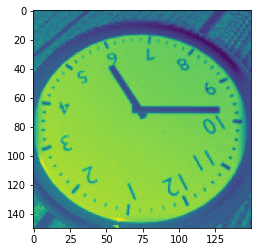

In [0]:
def improve(X, v=0.1):
    # Increase contrast a bit. Relevant stuff in images is black.
    def stuff(image): 
        # Now I try to sort of increase the contrast.
        # TODO: flip pixels at reflection?
        image -= v
        image[image < 0.8] -= v
        image[image < 0.5] -= v
        image[image > 1] = 1
        image[image < 0] = 0
        return image
    return np.array([stuff(image) for image in X])

i = np.random.randint(0, 50)
plt.imshow(X[i, :, :, 0])

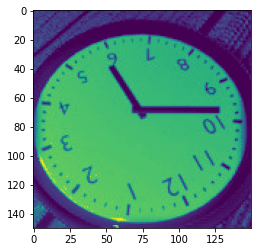

In [0]:
plt.imshow(improve(X[:50])[i, :, :, 0])

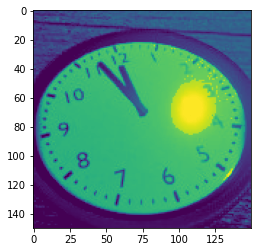

In [0]:
if True:
    plt.imshow(X[42, :, :, 0]) # pre ...
    X = improve(X)

X_train = X[:n_train]
X_test = X[n_train:]
y_train_p = y[:n_train]
y_test_p = y[n_train:]
# Reserve name without _p suffix for categorical

del X # it's big

if False: # i.e., if RAM 
    # Create bigger training set with square 90s rotations and some noise
    X_train = np.repeat(X_train, 4, axis=0)
    n_train = X_train.shape[0]
    X_train = [np.rot90(image, i % 4) + np.random.normal(0, 20) 
               for i, image in enumerate(X_train)]
    print(X_train.shape)
    y_train_p = np.repeat(y_train_p, 4, axis=0)

y_hours_train = keras.utils.to_categorical(y_train_p[:,0])
y_minutes_train = keras.utils.to_categorical(y_train_p[:,1])
y_hours_test = keras.utils.to_categorical(y_test_p[:,0])
y_minutes_test = keras.utils.to_categorical(y_test_p[:,1])
y_train = y_hours_train, y_minutes_train
y_test = y_hours_test, y_minutes_test

[0.07527778 0.08805556 0.07222222 0.08305556 0.08583333 0.08777778
 0.08611111 0.08805556 0.08333333 0.08444444 0.08694444 0.07888889]
[0.01861111 0.01583333 0.01472222 0.01527778 0.01694444 0.01611111
 0.01916667 0.01444444 0.0175     0.01555556 0.01333333 0.01805556
 0.01527778 0.01861111 0.01555556 0.01777778 0.01666667 0.01861111
 0.01694444 0.01583333 0.01666667 0.015      0.015      0.01444444
 0.01666667 0.01444444 0.01611111 0.01944444 0.01777778 0.0175
 0.01666667 0.01833333 0.01555556 0.01527778 0.01666667 0.01666667
 0.01611111 0.01777778 0.01722222 0.01277778 0.02027778 0.0175
 0.01611111 0.01472222 0.01583333 0.01638889 0.01555556 0.01694444
 0.01416667 0.01944444 0.01916667 0.01638889 0.01833333 0.01555556
 0.01833333 0.01944444 0.01694444 0.01361111 0.01722222 0.02111111]


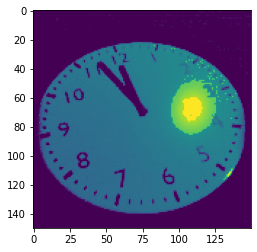

In [0]:
 # Checks
print((y_hours_test != 0).sum(0) / n_test)
print((y_minutes_test != 0).sum(0) / n_test)
plt.imshow(X_train[42, :, :, 0])

In [0]:
def common_sense_loss(hours_predicted, minutes_predicted,
                      hours_true, minutes_true):
    pred = 60 * hours_predicted + minutes_predicted
    true = 60 * hours_true + minutes_true
    delta_time = abs(pred - true)
    return delta_time % 720

def hour_loss_tf(hrpred, hrtr):
    # Of course we can't expect this to work well if the minute hand is near 30.
    # Messing with the tensors that come into this function (also if the model
    # has only one ouput) is very annoying, and we have not managed to do it.
    delta_hours = tf.subtract(hrpred, hrtr)    
    time_error_h = tf.minimum(tf.math.mod(delta_hours, 12.0),
                              tf.math.mod((-1 * delta_hours), 12.0))
    return tf.reduce_mean(time_error_h)

def minute_loss_tf(minpred, mintr):
    delta_minutes = tf.subtract(minpred, mintr)
    time_error_m = tf.minimum(tf.math.mod(delta_minutes, 60.0),
                              tf.math.mod((-1 * delta_minutes), 60.0))
    return tf.reduce_mean(time_error_m)

input_thing = Input(img_size)

# TODO: mess with structures
x = Conv2D(64, (4, 4), (2,2), activation='relu')(input_thing)
x = MaxPool2D()(x)
x = Dropout(0.1)(x)
x = Conv2D(64, (4, 4), activation='relu')(x)
x = MaxPool2D()(x)
x = Dropout(0.1)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPool2D()(x)
x = Dropout(0.1)(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPool2D()(x)
x = Dropout(0.35)(x)
x = Flatten()(x)
x = Dropout(0.05)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
hour = minute = x
hour = Dense(64, activation='relu')(hour)
hour = Dropout(0.2)(hour)
minute = Dense(256, activation='relu')(minute)
minute = Dropout(0.2)(minute)

hour = Dense(12, activation='softmax', name='hour')(hour)
minute = Dense(60, activation='softmax', name='minute')(minute)

model = keras.models.Model(inputs=[input_thing], outputs=[hour, minute])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 64)   1088        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 37, 37, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 37, 37, 64)   0           max_pooling2d[0][0]              
______________________________________________________________________________________________

In [0]:
gc.collect()

model.compile(
    loss=['categorical_crossentropy' for _ in range(2)], metrics=['accuracy'],
    # loss=[hour_loss_tf, minute_loss_tf], # no metric because interpretable
    loss_weights=[0.6, 0.4], # theoretically [1, 12 / 60]
    optimizer=Adam(learning_rate=0.0003)) # .0005 is about the max with x ent

fit = model.fit(X_train, y_train, epochs=300, batch_size=24, 
                # use_multiprocessing=True, # if only...
                validation_split=.05)
                #validation_data=(X_test, y_test))

predictions = model.predict(X_test)

Epoch 1/300
570/570 [==============================] - 6s 11ms/step - loss: 3.2904 - hour_loss: 2.4854 - minute_loss: 4.0954 - hour_accuracy: 0.0849 - minute_accuracy: 0.0151 - val_loss: 3.2901 - val_hour_loss: 2.4851 - val_minute_loss: 4.0951 - val_hour_accuracy: 0.0903 - val_minute_accuracy: 0.0139
Epoch 2/300
570/570 [==============================] - 6s 10ms/step - loss: 3.2899 - hour_loss: 2.4851 - minute_loss: 4.0946 - hour_accuracy: 0.0853 - minute_accuracy: 0.0156 - val_loss: 3.2902 - val_hour_loss: 2.4850 - val_minute_loss: 4.0953 - val_hour_accuracy: 0.0903 - val_minute_accuracy: 0.0167
Epoch 3/300
570/570 [==============================] - 6s 10ms/step - loss: 3.2897 - hour_loss: 2.4850 - minute_loss: 4.0945 - hour_accuracy: 0.0834 - minute_accuracy: 0.0152 - val_loss: 3.2904 - val_hour_loss: 2.4850 - val_minute_loss: 4.0957 - val_hour_accuracy: 0.0861 - val_minute_accuracy: 0.0097
Epoch 4/300
570/570 [==============================] - 6s 10ms/step - loss: 3.2897 - hour_loss

In [0]:
predicted_times = []
loss = 0
for i in range(len(predictions[0])):
    ph = predictions[0][i].argmax()
    pm = predictions[1][i].argmax()
    predicted_times.append((ph, pm))
    th = y_test[0][i].argmax()
    tm = y_test[1][i].argmax()
    loss += common_sense_loss(ph, pm, th, tm)
loss /= n_test
print("Common sense loss of model on test set:", loss)
if loss < 3: model.save(dot + str(loss) + ' lost at ' + \
                         str(time.asctime(time.localtime())))

Common sense loss of model on test set: 2.1594444444444445
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/MSc/S2 Deep Learning and Neural Networks/Assignment 2/2.1594444444444445 lost at Sat Apr 25 07:26:14 2020/assets


In [0]:
print("Predicted / true\n---")
for i in np.random.permutation(42):
    print(predicted_times[i], "/",
          (y_hours_test[i].argmax(), y_minutes_test[i].argmax()))

Predicted / true
---
(6, 19) / (6, 19)
(2, 50) / (2, 49)
(3, 26) / (3, 29)
(3, 10) / (3, 11)
(8, 1) / (8, 0)
(0, 25) / (0, 25)
(11, 39) / (11, 37)
(6, 28) / (6, 28)
(0, 13) / (0, 10)
(8, 23) / (8, 22)
(2, 57) / (2, 57)
(9, 2) / (9, 3)
(10, 50) / (10, 51)
(11, 44) / (11, 44)
(7, 29) / (7, 28)
(1, 59) / (0, 59)
(2, 48) / (2, 48)
(1, 50) / (1, 51)
(11, 23) / (11, 23)
(9, 22) / (9, 24)
(9, 35) / (9, 35)
(4, 59) / (4, 58)
(0, 52) / (0, 52)
(10, 41) / (10, 40)
(0, 1) / (0, 2)
(7, 33) / (7, 34)
(2, 50) / (2, 50)
(9, 58) / (9, 58)
(9, 6) / (9, 7)
(10, 37) / (10, 38)
(11, 35) / (11, 35)
(0, 21) / (0, 22)
(8, 49) / (8, 50)
(11, 6) / (11, 6)
(3, 12) / (3, 13)
(2, 26) / (2, 26)
(7, 4) / (7, 4)
(4, 50) / (4, 50)
(4, 51) / (4, 50)
(4, 46) / (4, 46)
(3, 22) / (3, 21)
(1, 30) / (1, 30)


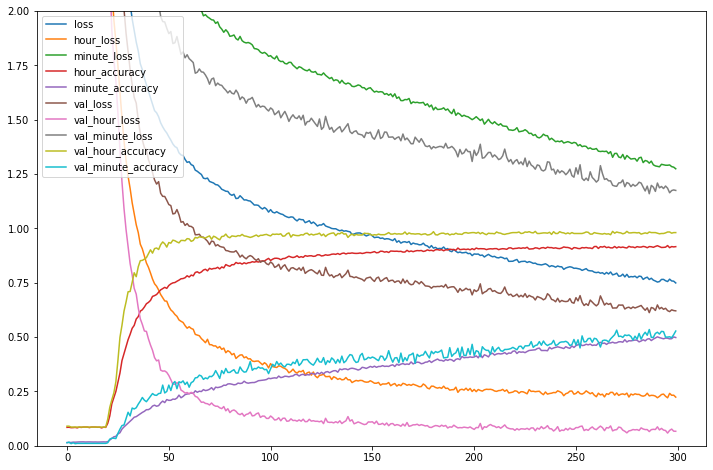

In [0]:
pd.DataFrame(fit.history).plot(figsize=(12, 8), ylim=(0,2))